Install appropriate packages and load in datasets from NHANES

In [1453]:
# !pip install xport pandas numpy matplotlib scikit-learn pyreadstat

In [1454]:
from xport import XportReader
import os
from pyreadstat import read_xport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC


In [1455]:
# Constants that can be changed
MISSINGNESS_THRESHOLD = 20
IMPUTATION_STRATEGY = 'mean'
KNN_NEIGHBORS = 5
BINARY_THRESHOLD = 10

In [1456]:
# DPQ_L.xpt is the dataset containg depression questions
with open("datasets/questionaire_data/DPQ_L.xpt", "rb") as f:
    reader = XportReader(f)
    depression_df = pd.DataFrame(reader)

Describe the dataset

In [1457]:
display(depression_df)

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,130378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,130379.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130380.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130386.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,130387.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6332,142305.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6333,142307.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6334,142308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6335,142309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


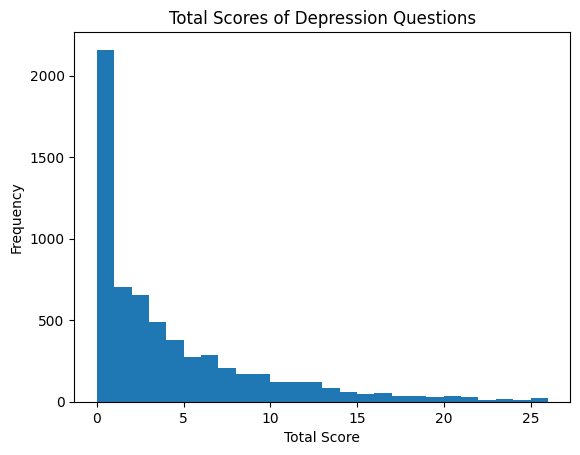

In [1458]:
# counts of total sums across all questions of last 10 columns only add if value is 1, 2, 3
depression_df["DPQSUM"] = depression_df.iloc[:, -10:].apply(lambda x: x[x.isin([1, 2, 3])].sum(), axis=1)

# histogram of the sums
plt.hist(depression_df["DPQSUM"], bins=range(0, 27, 1))
plt.title("Total Scores of Depression Questions")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

Load in the other data sets for prediction and casual understanding of depression scores

In [1459]:
base_dir = "datasets"
dataframes = {}

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".xpt"):
            file_path = os.path.join(root, file)
            dataset_name = os.path.splitext(file)[0]
            new_df = pd.read_sas(file_path, format='xport', encoding='latin1')
            dataframes[dataset_name] = new_df

c:\Users\Simon\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


Overlapping SEQNs among all datasets

In [1460]:
filtered_dataframes = []

for name, df in dataframes.items():
    missingness = df.isnull().mean() * 100
    low_missingness_cols = missingness[missingness <= MISSINGNESS_THRESHOLD].index
    filtered_df = df[low_missingness_cols]
    filtered_dataframes.append(filtered_df)

filtered_dataframes.append(depression_df)

# Find common SEQNs across all DataFrames
common_seqn = set(filtered_dataframes[0]["SEQN"])
for df in filtered_dataframes[1:]:
    common_seqn = common_seqn.intersection(df["SEQN"])

# Filter DataFrames to include only rows with common SEQNs
filtered_dataframes = [df[df["SEQN"].isin(common_seqn)] for df in filtered_dataframes]


In [1461]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='inner'), filtered_dataframes)

display(merged_df)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMDBORN4,DMDHHSIZ,WTINT2YR,...,DPQ020_y,DPQ030_y,DPQ040_y,DPQ050_y,DPQ060_y,DPQ070_y,DPQ080_y,DPQ090_y,DPQ100,DPQSUM
0,130378.0,12.0,2.0,1.0,43.0,5.0,6.0,2.0,4.0,50055.450807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,130379.0,12.0,2.0,1.0,66.0,3.0,3.0,1.0,2.0,29087.450605,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,130380.0,12.0,2.0,2.0,44.0,2.0,2.0,2.0,7.0,80062.674301,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,130386.0,12.0,2.0,1.0,34.0,1.0,1.0,1.0,3.0,30995.282610,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,130387.0,12.0,2.0,2.0,68.0,3.0,3.0,1.0,1.0,19896.970559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4766,142300.0,12.0,2.0,2.0,46.0,1.0,1.0,2.0,5.0,28399.611503,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4767,142303.0,12.0,2.0,2.0,69.0,5.0,7.0,1.0,2.0,33250.569425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4768,142307.0,12.0,2.0,2.0,49.0,4.0,4.0,1.0,5.0,69419.620456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4769,142308.0,12.0,2.0,1.0,50.0,2.0,2.0,2.0,3.0,32696.313477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [1462]:
# Fix physical activity columns to be standardized

unit_conversion = {'D': 365, 'W': 52.14, 'M': 12, 'Y': 1}

def standardize_frequency(row, freq_col, unit_col):
    if pd.isna(row[unit_col]) or pd.isna(row[freq_col]):
        return None  
    return row[freq_col] * unit_conversion.get(row[unit_col], 1)

merged_df['PAD790_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD790Q', 'PAD790U'), axis=1)

merged_df['PAD810_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD810Q', 'PAD810U'), axis=1)

# merged_df['PAD790_total_minutes'] = merged_df['PAD790_annualized'] * merged_df['PAD800']
# merged_df['PAD810_total_minutes'] = merged_df['PAD810_annualized'] * merged_df['PAD820']

# merged_df = merged_df.drop(columns=['PAD800', 'PAD820'])
merged_df = merged_df.drop(columns=['PAD790Q', 'PAD790U', 'PAD810Q', 'PAD810U'])

In [1463]:
# Deal with non-numeric columns
for col in ['SLQ300', 'SLQ310', 'SLQ320', 'SLQ330']:
    merged_df[col] = pd.to_numeric(merged_df[col].str.replace(r'\D', ''), errors='coerce')

C:\Users\Simon\AppData\Local\Temp\ipykernel_42896\1654022778.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df[col] = pd.to_numeric(merged_df[col].str.replace(r'\D', ''), errors='coerce')


In [1464]:
if IMPUTATION_STRATEGY == 'KNN':
    imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)
else:
    imputer = SimpleImputer(strategy=f'{IMPUTATION_STRATEGY}')

merged_df = pd.DataFrame(imputer.fit_transform(merged_df), columns=merged_df.columns)

In [1465]:
# need just one column for depression score not individual questions, but keep dpq sum column
merged_df = merged_df.drop(columns=merged_df.columns[merged_df.columns.str.startswith("DPQ") & ~merged_df.columns.str.startswith("DPQSUM")])

# dpqsum at end
merged_df = merged_df[[c for c in merged_df if c != 'DPQSUM'] + ['DPQSUM']]

In [ ]:
# split up target (dpqsum) two different ways: binary (depressed or not) and continuous (minimal, mild, moderate, moderately severe, severe)
# Binary: 0-9 not depressed, 10-27 depressed
# Continuous: 0-4 minimal, 5-9 mild, 10-14 moderate, 15-19 moderately severe, 20-27 severe

merged_df["DEPRESSED"] = merged_df["DPQSUM"].apply(lambda x: 1 if x >= BINARY_THRESHOLD else 0)
merged_df["DEPRESSION_LEVEL"] = merged_df["DPQSUM"].apply(lambda x: 1 if x < 5 else 2 if x < 10 else 3 if x < 15 else 4 if x < 20 else 5)

# distribution of these targets
print("Binary Target Distribution:")
print(merged_df["DEPRESSED"].value_counts())
print("Continuous Target Distribution:")
print(merged_df["DEPRESSION_LEVEL"].value_counts())

Binary Target Distribution:
0    4099
1     672
Name: DEPRESSED, dtype: int64
Continuous Target Distribution:
1    3235
2     864
3     411
4     159
5     102
Name: DEPRESSION_LEVEL, dtype: int64


In [1467]:
not_depressed = merged_df[merged_df['DEPRESSED'] == 0]
depressed = merged_df[merged_df['DEPRESSED'] == 1]

# randomly remove some not depressed samples to balance the dataset
not_depressed_downsampled = resample(not_depressed, replace=False, n_samples=len(depressed), random_state=42)

balanced_df = pd.concat([not_depressed_downsampled, depressed])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("New Binary Target Distribution:")
print(balanced_df['DEPRESSED'].value_counts())

New Binary Target Distribution:
0    672
1    672
Name: DEPRESSED, dtype: int64


In [1468]:
# remove dpqsum column
balanced_df = balanced_df.drop(columns="DPQSUM")

display(balanced_df)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMDBORN4,DMDHHSIZ,WTINT2YR,...,SMQ020,SMAQUEX2,WHD010,WHD020,WHD050,WHQ070,PAD790_annualized,PAD810_annualized,DEPRESSED,DEPRESSION_LEVEL
0,137537.0,12.0,2.0,2.0,37.0,1.0,1.0,1.0,4.0,26712.638364,...,2.0,1.0,65.0,175.0,165.0,1.0,1.042800e+02,5.214000e+01,0,1
1,134296.0,12.0,2.0,1.0,69.0,3.0,3.0,1.0,2.0,25387.930391,...,2.0,1.0,63.0,184.0,184.0,1.0,3.649800e+02,5.397605e-79,0,1
2,135674.0,12.0,2.0,2.0,25.0,3.0,3.0,1.0,4.0,23370.552508,...,2.0,1.0,64.0,155.0,180.0,1.0,1.564200e+02,1.200000e+01,1,3
3,136946.0,12.0,2.0,1.0,67.0,3.0,3.0,1.0,2.0,33050.051273,...,1.0,1.0,68.0,178.0,178.0,2.0,2.085600e+02,5.397605e-79,0,1
4,138395.0,12.0,2.0,2.0,39.0,3.0,3.0,1.0,1.0,36965.767759,...,2.0,1.0,70.0,160.0,168.0,1.0,1.042800e+02,5.397605e-79,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,138011.0,12.0,2.0,2.0,68.0,3.0,3.0,1.0,4.0,16076.247553,...,2.0,1.0,66.0,195.0,185.0,1.0,5.214000e+01,5.397605e-79,1,5
1340,138517.0,12.0,2.0,1.0,30.0,3.0,3.0,1.0,1.0,24123.683391,...,1.0,1.0,73.0,170.0,170.0,2.0,5.214000e+01,1.200000e+01,1,3
1341,141264.0,12.0,2.0,2.0,50.0,2.0,2.0,1.0,2.0,16459.015513,...,1.0,1.0,59.0,158.0,168.0,1.0,1.564200e+02,1.564200e+02,1,3
1342,133882.0,12.0,2.0,2.0,65.0,4.0,4.0,1.0,3.0,44676.554600,...,2.0,1.0,62.0,200.0,165.0,1.0,5.397605e-79,5.397605e-79,1,4


In [1469]:
X = balanced_df.drop(columns=["DEPRESSED", "DEPRESSION_LEVEL"])
y_binary = balanced_df["DEPRESSED"]
y_continuous = balanced_df["DEPRESSION_LEVEL"]
X_train, X_test, y_binary_train, y_binary_test, y_continuous_train, y_continuous_test = train_test_split(X, y_binary, y_continuous, test_size=0.2, random_state=42)

In [1470]:
# identify NaN values in the dataset
print(X_train.isna().sum().sum())

0


In [1471]:
results = {}

Try Random Forest model

In [1472]:
randomForest = RandomForestClassifier(random_state=42, max_depth=3, n_estimators=100)
randomForest.fit(X_train, y_binary_train)

y_binary_pred = randomForest.predict(X_test)
print("Binary Target Accuracy:", accuracy_score(y_binary_test, y_binary_pred))
print("Binary Target Classification Report:")
print(classification_report(y_binary_test, y_binary_pred))

Binary Target Accuracy: 0.7769516728624535
Binary Target Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       144
           1       0.75      0.78      0.77       125

    accuracy                           0.78       269
   macro avg       0.78      0.78      0.78       269
weighted avg       0.78      0.78      0.78       269



In [1473]:
scores = cross_val_score(randomForest, X, y_binary, cv=5)
print("Random Forest Mean Score:", scores.mean())
results["Random Forest"] = scores.mean()

Random Forest Mean Score: 0.7366198746046718


Try Logistic Regression Model

In [1474]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr_scores = cross_val_score(lr_model, X_scaled, y_binary, cv=5)
print("Logistic Regression Mean Score:", lr_scores.mean())
results["Logistic Regression"] = lr_scores.mean()

Logistic Regression Mean Score: 0.7172529545580646


In [1475]:
svm = SVC(kernel='rbf', random_state=42)
cv_scores = cross_val_score(svm, X_scaled, y_binary, cv=5)
print("SVM Mean Score:", cv_scores.mean())
results["SVM"] = cv_scores.mean()

SVM Mean Score: 0.7165205570659713


In [1476]:
xgboost_model = XGBClassifier()
scores = cross_val_score(xgboost_model, X.to_numpy(), y_binary, cv=5, error_score='raise')
print("XGBoost Mean Score:", scores.mean())
results["XGBoost"] = scores.mean()

XGBoost Mean Score: 0.7514980857792821


In [1477]:
lgbm = LGBMClassifier(random_state=42)
cv_scores = cross_val_score(lgbm, X, y_binary, cv=5)
print("LightGBM Mean Score:", cv_scores.mean())
results["LightGBM"] = cv_scores.mean()

[LightGBM] [Info] Number of positive: 538, number of negative: 537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 1075, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500465 -> initscore=0.001860
[LightGBM] [Info] Start training from score 0.001860
[LightGBM] [Info] Number of positive: 538, number of negative: 537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3738
[LightGBM] [Info] Number of data points in the train set: 1075, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500465 -> initscore=0.001860
[LightGBM] [Info] Start training from score 0.001860
[LightGBM] [Info] Number o

In [1478]:
meta_model = LogisticRegression(max_iter=1000, random_state=42)

stacked_model = StackingClassifier(
    estimators=[
        ('rf', randomForest),
        # ('lr', lr_model),
        ('xgb', xgboost_model),
        ('lgbm', lgbm),
        # ('svm', svm)
    ],
    final_estimator=meta_model,
    cv=5
)

stacked_scores = cross_val_score(stacked_model, X, y_binary, cv=5)
print("Stacked Model Mean Score:", stacked_scores.mean())
results["Stacked Model"] = stacked_scores.mean()

[LightGBM] [Info] Number of positive: 538, number of negative: 537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3750
[LightGBM] [Info] Number of data points in the train set: 1075, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500465 -> initscore=0.001860
[LightGBM] [Info] Start training from score 0.001860
[LightGBM] [Info] Number of positive: 431, number of negative: 429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3606
[LightGBM] [Info] Number of data points in the train set: 860, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501163 -> initscore=0.004651
[LightGBM] [Info] Start training from score 0.004651
[LightGBM] [Warning] No fur

In [1479]:
for model, score in results.items():
    print(f"{model} Mean Score: {score}")

Random Forest Mean Score: 0.7366198746046718
Logistic Regression Mean Score: 0.7172529545580646
SVM Mean Score: 0.7165205570659713
XGBoost Mean Score: 0.7514980857792821
LightGBM Mean Score: 0.7462908505798147
Stacked Model Mean Score: 0.7559701492537314


In [ ]:
!pip install econml